---
layout: post
category: blog
title: Predict Economic Indicators with OpenStreetMap
tags: [OpenStreetMap, Overpass API, GIS, Python]
image: /assets/OperationsSpecialistVTS.jpg
imageurl: https://en.wikipedia.org/wiki/File:OperationsSpecialistVTS.jpg
imagesource: Wikimedia Commons
---

[OpenStreetMap](https://www.openstreetmap.org/) (OSM) is a massive collaborative map of the world, built and maintained mostly by volunteers. On the other hand, there exist various indicators to measure economic growth, prosperity, and produce of a country. What if we use OpenStreetMap to predict those economic indicators?

One inspiration for this project came from the publication _Measuring Economic Growth from Outer Space_ where they tried to predict the GDP growth of countries with satellite data at night. Their aim was to have an alternative way to measure economic growth since reliable data on economic growth is difficult to come by, especially in rural areas.

![Outer Space Economics](assets/eastern_europe_in_lights.jpg)

_Henderson, J. Vernon, Adam Storeygard, and David N. Weil. "Measuring economic growth from outer space." American economic review 102.2 (2012): 994-1028._

Instead of measuring lights, here we will focus on the various amenities like universities, ATMs, parking spaces and others found in OSM within each of the countries in the European Union (EU) and member states of the European free trade association (EFTA). The objective is to see which of those amenities correlate most with the selected economic indicators. All the necessary scripts to collect and clean the data from OSM and the economic indicators can be found in this [repository](https://github.com/njanakiev/osm-predict-economic-measurements).

# Measurements in Economics

There are various ways to measure the macroeconomic performance of a given country. The key measures of economic performance include economic growth (e.g. real GDP growth), inflation, unemployment and current account (e.g. low deficit). The focus in this project were three particular indicators, the Gross Domestic Product (GDP), the Human Development Index (HDI) and the Big Mac Index.

But before getting to the indicators we need to take a quick look at the [Purchasing Power Parity](https://en.wikipedia.org/wiki/Purchasing_power_parity) (PPP). [Purchasing Power](https://en.wikipedia.org/wiki/Purchasing_power) is the number of goods you can get for one currency and PPP is the ratio of two countries' purchasing power. This is done by a market basket of goods approach, where the PPP rates are determined by comparing the prices of identical items in different countries. PPP is often used to make more accurate comparisons between two countries gross domestic product (GDP) instead of those that can be made when using market exchange rates. In this project, the GDP and GNI are based on a purchasing power parity converting them to the international dollar as a common currency.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

df_targets = pd.read_csv('data/economic_measurements.csv', index_col='country')
df_targets.drop(columns='country_code', inplace=True)
df_targets = df_targets[['Population', 'GNI', 'GDP', 'BM Dollar', 'HDI']]
df_targets.head()

,Population,GNI,GDP,BM Dollar,HDI
country,,,,,
Belgium,11338476.0,42367.993039,46428.671425,5.019425,0.895514
Bulgaria,7127822.0,17758.415202,19242.622616,NaN,0.793642
Czech Republic,10566332.0,29279.681889,34749.212363,3.807779,0.877842
Denmark,5728010.0,47160.293155,49029.014839,4.932020,0.924649
Germany,82487842.0,45126.504599,48860.525292,4.774575,0.925669


## Gross Domestic Product and Gross National Income

One of the most well-known economic metrics is the [Gross Domestic Product](https://en.wikipedia.org/wiki/Gross_domestic_product) (GDP) which is defined by the [OECD](http://stats.oecd.org/glossary/detail.asp?ID=1163) as _an aggregate measure of production equal to the sum of the gross value added of all resident and institutional units engaged in production_. In simple terms, this measures the market value of all goods and services produced in a country within a period of time (e.g. in one year).

[Gross National Income](https://en.wikipedia.org/wiki/Gross_national_income) (GNI) on the other hand is a measure of a country's income. The main difference to GDP is that GDP exclusively counts income received from domestic sources and GNI includes the net income received from abroad. In most cases GDP and GNI are close. But if the GNI is much higher than the GDP this can mean that the country receives large amounts of foreign aid. In the opposite case where GDP is much higher, it can mean that there are subsidiaries of multinational companies in this country because of low taxes which can be seen in the comparison below for Ireland and Luxembourg.

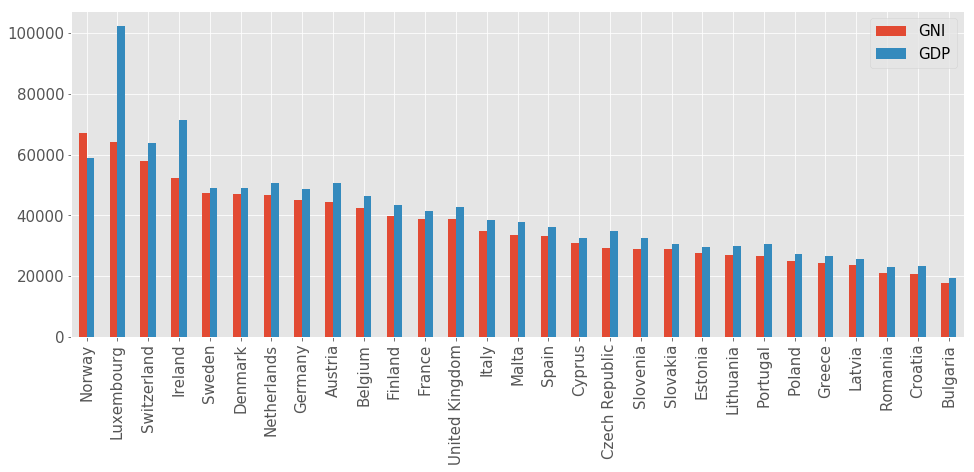

In [12]:
df_plot = df_targets[['GNI', 'GDP']].sort_values(by='GNI', ascending=False).dropna()
df_plot.plot(kind='bar', figsize=(16, 6), fontsize=15)
plt.xlabel(''); plt.legend(fontsize=15);

## Human Development Index

The [Human Development Index](http://hdr.undp.org/en/content/human-development-index-hdi) (HDI) is a composite index consisting of life expectancy, education and per capita income indicators which are used to rank countries by their human development. The index was developed by the Pakistani economist _Mahbub ul Haq_ for the [United Nations Development Programme](http://www.undp.org/content/undp/en/home.html) (UNDP) to assess the development of a country and not economic growth alone.

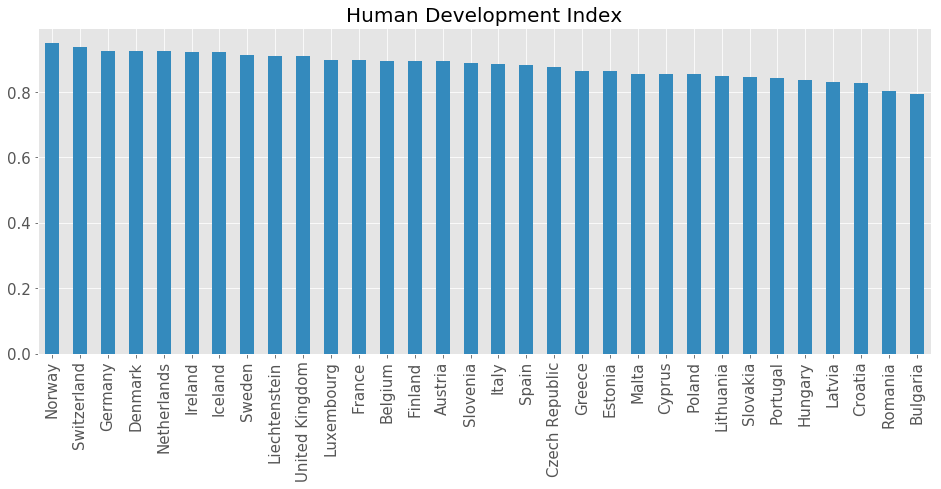

In [242]:
df_plot = df_targets['HDI'].sort_values(ascending=False)
df_plot.plot(kind='bar', figsize=(16, 6), fontsize=15, color='C1')
plt.title('Human Development Index', fontsize=20); plt.xlabel('');

## Big Mac Index

The final indicator in our selection is the [Big Mac Index](https://www.economist.com/content/big-mac-index) which was created by the Economist Magazine in 1986 as an informal way of comparing purchasing power between currencies against the U.S. Dollar. McDonald's is available in 119 different countries and one particular thing about McDonald's is its consistency in its products among its stores. This means the same items are made in the same way with the same ingredients in very different economies around the world, making the Big Mac a suitable candidate for a market basket of goods for the PPP. This can efficiently show which currencies are under or overvalued compared to other currencies. This makes it a prime example of the purchasing power parity discussed before.

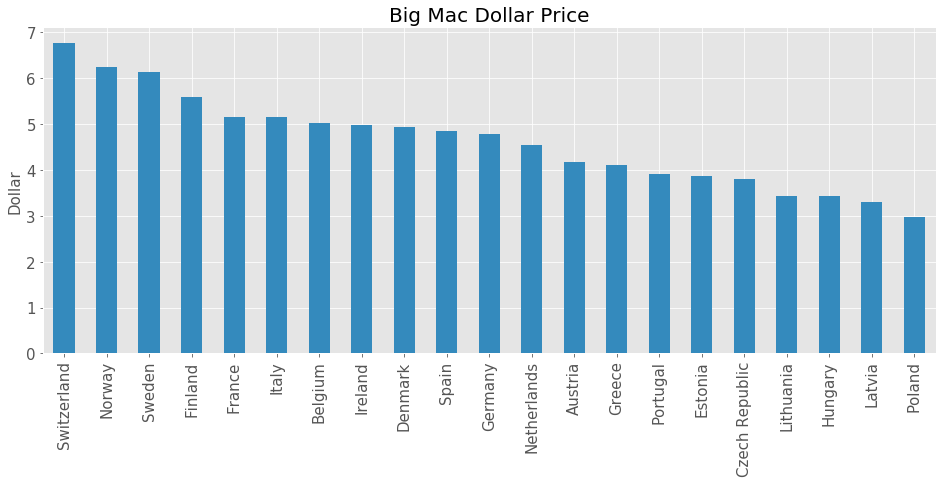

In [241]:
df_plot = df_targets['BM Dollar'].sort_values(ascending=False).dropna()
df_plot.plot(kind='bar', figsize=(16, 6), fontsize=15, color='C1')
plt.title('Big Mac Dollar Price', fontsize=20);
plt.xlabel(''); plt.ylabel('Dollar', fontsize=15);

# Loading Data from OpenStreetMap

Having our economic indicators in place, we can now move on to select the desired amenities in OSM. There are various [elements](https://wiki.openstreetmap.org/wiki/Elements) in OSM, which can be associated with [tags](https://wiki.openstreetmap.org/wiki/Tags) consisting of key-value pairs. One useful key is the [amenity](https://wiki.openstreetmap.org/wiki/Key:amenity) key, which tags various community facilities like _university_, _school_, _restaurant_ or others.

The goal in our data acquisition is to get the 50 most used values for the amenity key (e.g. amenity=parking) for each country. A great website to explore worldwide statistics for key-values tags found in OSM is [taginfo](https://taginfo.openstreetmap.org/), where the most common amenities can be found in this [list](https://taginfo.openstreetmap.org/keys/amenity#values). The 50 most common values were automatically collected with the [taginfo API](https://taginfo.openstreetmap.org/taginfo/apidoc). Next step is to collect the counts for each of the 50 amenities for each country. This is done with the [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) and the [Overpass QL](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL) which enables specific access to OSM without having to download the whole data set. More information on how to work with the Overpass API can be found in this [article]({{ site.baseurl }}{% link _posts/2018-03-04-openstreetmap-with-python-and-overpass-api.md %}). The next example snippet shows how to get the number of all benches in Germany.

In [3]:
import requests

overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
area["ISO3166-1"="DE"][admin_level=2]->.search;
node["amenity"="bench"](area.search);
out count;"""

response = requests.get(overpass_url, params={'data': overpass_query})
print(response.text)

<?xml version="1.0" encoding="UTF-8"?>
<osm version="0.6" generator="Overpass API 0.7.55 579b1eec">
<note>The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.</note>
<meta osm_base="2018-05-16T10:51:02Z" areas="2018-05-16T10:42:02Z"/>

  <count id="0">
    <tag k="nodes" v="333165"/>
    <tag k="ways" v="0"/>
    <tag k="relations" v="0"/>
    <tag k="areas" v="0"/>
    <tag k="total" v="333165"/>
  </count>

</osm>



## Load and normalize OSM Counts

Next step is to load the amenities for each country. Since we have also the population of each country, we want to normalize the counts to have an amenity per capita measure. This makes it easier to compare the countries. Additionally, we want to replace all amenities with count 0 to 0.1, which is helpful when visualizing the data set with a logarithmic scale.

The population data is from the [World Bank Open Data](https://data.worldbank.org/) and the population count is from 2016. The same applies to the GDP and GNI data, which are also from the World Bank from 2016.

In [5]:
df_amenity = pd.read_csv('data/country_amenity_counts.csv')
df_amenity.set_index('country', inplace=True)
df_amenity.drop(columns='country_code', inplace=True)

# Replace 0 values with 0.1
df_amenity = df_amenity.applymap(lambda x: 0.1 if x == 0 else float(x))

# Normalize amenities    
df_amenity_normalized = df_amenity.apply( 
    lambda row: row / df_targets['Population'].loc[row.name], axis=1)

df_amenity.head()

,parking,place_of_worship,school,bench,restaurant,fuel,cafe,fast_food,bank,waste_basket,...,waste_disposal,marketplace,bus_station,university,college,parking_entrance,swimming_pool,theatre,taxi,veterinary
country,,,,,,,,,,,,,,,,,,,,,
Belgium,33209.0,6644.0,5936.0,15257.0,7549.0,2414.0,2496.0,3441.0,2529.0,9439.0,...,80.0,124.0,79.0,520.0,248.0,430.0,408.0,333.0,79.0,370.0
Bulgaria,4978.0,1964.0,1686.0,372.0,2828.0,1437.0,1353.0,710.0,925.0,72.0,...,68.0,182.0,222.0,162.0,51.0,56.0,84.0,121.0,193.0,81.0
Czech Republic,29815.0,8010.0,3768.0,14759.0,10271.0,2580.0,2057.0,2069.0,1291.0,2424.0,...,335.0,98.0,444.0,280.0,487.0,352.0,118.0,374.0,65.0,290.0
Denmark,32094.0,2620.0,2249.0,4168.0,2840.0,1810.0,3067.0,6780.0,682.0,1122.0,...,100.0,49.0,219.0,181.0,126.0,263.0,18.0,178.0,131.0,65.0
Germany,403687.0,62159.0,38465.0,333044.0,94386.0,17898.0,28377.0,31867.0,25452.0,61599.0,...,2054.0,1494.0,1842.0,2624.0,1188.0,8359.0,120.0,2596.0,4054.0,3417.0


Now let's take a look at how the amenities are distributed.

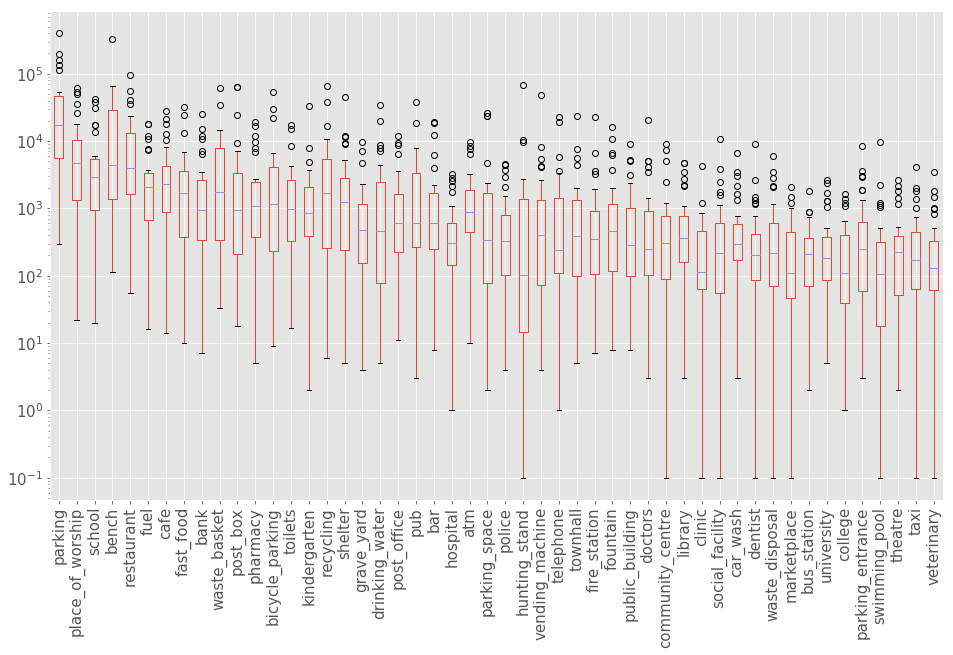

In [61]:
df_amenity.plot(kind='box', figsize=(16, 9), rot=90, logy=True, fontsize=15);

With this data, we can explore for example which country has the most benches, restaurants, schools or any other amenity that peaks our interest. Note that since OSM is based mostly on community contributions, the data might be incomplete or in some places even too detailed compared to others. It is important to be aware of this possible bias, but we can assume that most amenities, as the more important tags, are more complete in this regard.

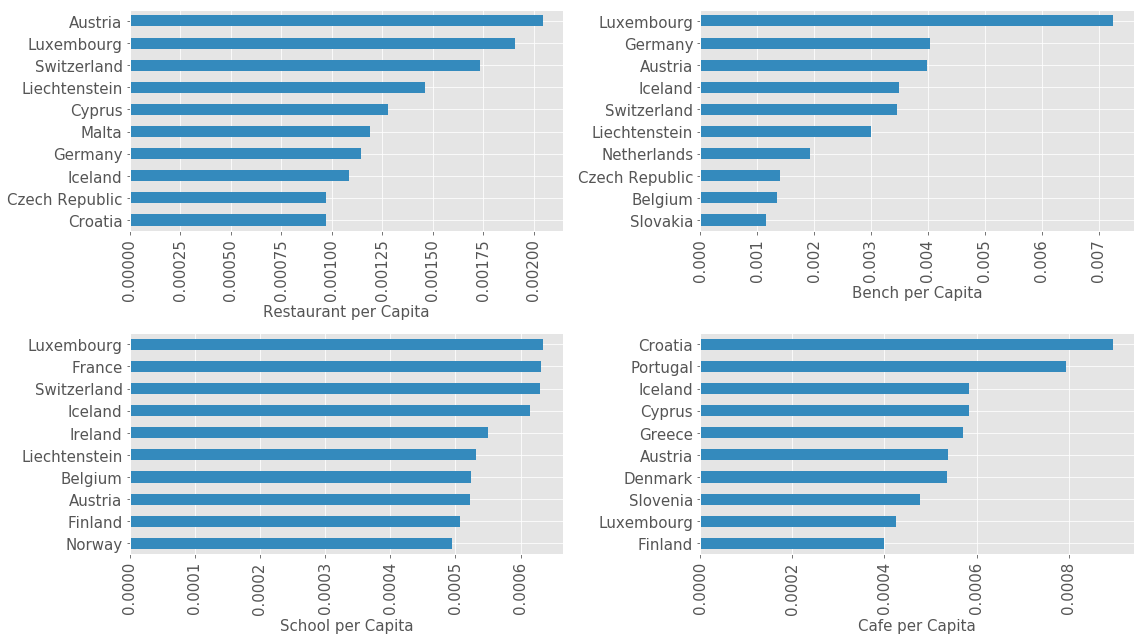

In [57]:
for i, amenity in enumerate(['restaurant', 'bench', 'school', 'cafe']):
    plt.subplot(2, 2, i + 1)
    df_plot = df_amenity_normalized[amenity].sort_values(ascending=True).iloc[-10:]
    df_plot.plot(kind='barh', color='C1', figsize=(16, 9), fontsize=15);
    plt.ylabel('');
    plt.xlabel('{} per Capita'.format(amenity.replace('_', ' ').title()), fontsize=15);
    plt.xticks(rotation=90);
plt.tight_layout()

# Correlation between Amenities and Economic Indicators

Now we will calculate the correlation for each amenity with all of the selected economic indicators to see which one seems to have the most influence. We are using the [Pearson Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient) to measure the linear correlation. For all economic indicators we will be using the normalized amenity counts and for the population, we will take the total amenity counts.

In [7]:
from scipy.stats import pearsonr

correlations, pvalues = [], []
for value in df_amenity:
    correlation_row, pvalue_row = [], []
    for economic_index in df_targets:
        if economic_index == 'Population':
            df_tmp = pd.concat([df_amenity[value], 
                                df_targets[economic_index]], axis=1).dropna()
        else:
            df_tmp = pd.concat([df_amenity_normalized[value], 
                                df_targets[economic_index]],axis=1).dropna()
            
        r, p = pearsonr(df_tmp[value], df_tmp[economic_index])
        correlation_row.append(r)
        pvalue_row.append(p)
    correlations.append(correlation_row)
    pvalues.append(pvalue_row)
    
df_corr = pd.DataFrame(correlations, index=df_amenity.columns, 
                       columns=df_targets.columns)
df_pvalues = pd.DataFrame(pvalues, index=df_amenity.columns, 
                          columns=df_targets.columns)
df_corr.head()

,Population,GNI,GDP,BM Dollar,HDI
parking,0.891240,0.685818,0.475158,0.466304,0.535464
place_of_worship,0.970164,0.097026,0.230531,-0.023596,0.101451
school,0.955610,0.750329,0.747299,0.654575,0.716739
bench,0.707870,0.587585,0.739734,0.218858,0.431660
restaurant,0.898616,0.389412,0.512864,0.276159,0.311712


Let's take a look a fairly obvious correlation, the correlation between population and number of amenities. We want to see which amenities are most correlated with the population. We expect that all amenities should have some correlation with the population.

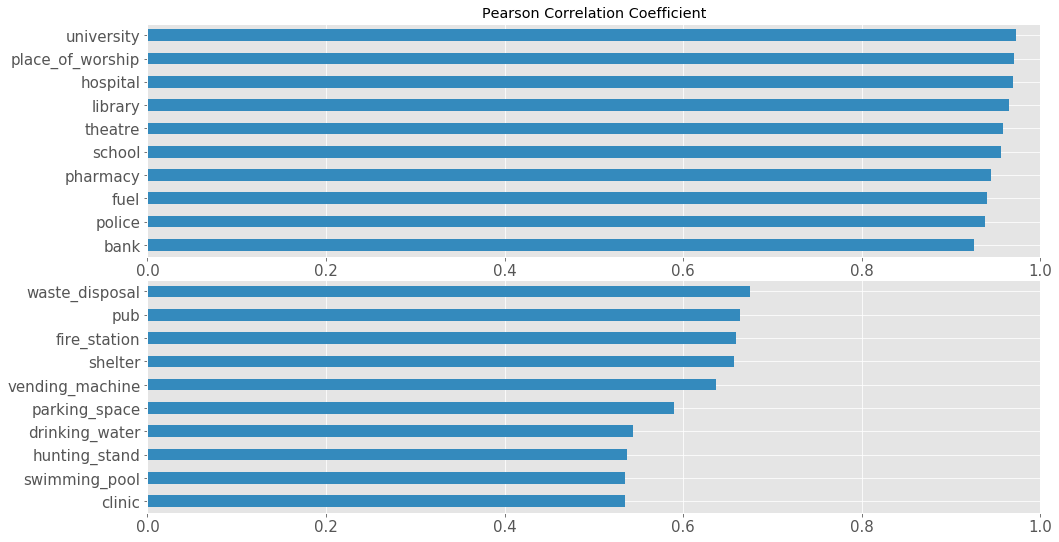

In [11]:
df_plot = df_corr['Population'].sort_values()
plt.figure(figsize=(16, 9))
plt.subplot(2, 1, 1)
df_plot[-10:].plot(kind='barh', fontsize=15, color='C1', 
                   title='Pearson Correlation Coefficient');
plt.xlim([0, 1])
plt.subplot(2, 1, 2)
df_plot[:10].plot(kind='barh', fontsize=15, color='C1');
plt.xlim([0, 1])
plt.subplots_adjust(hspace=0.1)

We can see that there is, in fact, a correlation present. After looking through the plots we can see that in many cases the outliers skew the correlation significantly, as we have only 32 countries to work with. According to the data the `amenity=university` has the strongest correlation and therefore predicts the population the best.

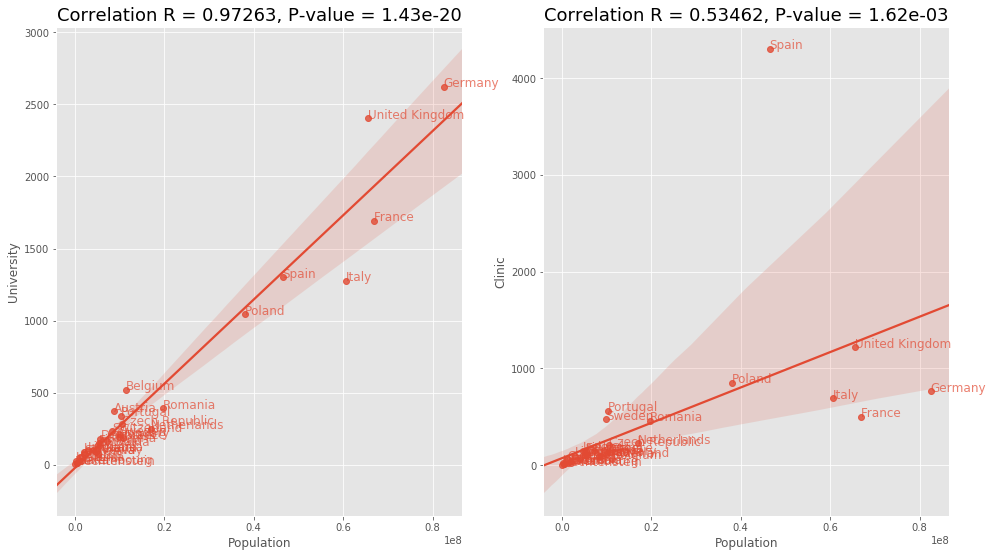

In [8]:
df_plot = pd.concat([df_targets, df_amenity], axis=1)
measurement = 'Population'

plt.figure(figsize=(16, 9))
for i, amenity in enumerate(['university', 'clinic']):
    plt.subplot(1, 2, i + 1)
    sns.regplot(x=measurement, y=amenity, data=df_plot, 
                fit_reg=True, ax=plt.gca())
    plt.ylabel(amenity.replace('_', ' ').title())
    plt.title('Correlation R = {:.5f}, P-value = {:.2e}'.format(
        df_corr.loc[amenity][measurement],
        df_pvalues.loc[amenity][measurement]),
        fontsize=18);
    
    for i, country in enumerate(df_plot.index):
        if not np.isnan(df_plot[measurement][i]):
            plt.annotate(country, 
                         (df_plot[measurement][i], df_plot[amenity][i]), 
                         fontsize=12, color='C0', alpha=0.7)

This was expected to see a correlation in this, but nevertheless interesting to see the most correlated amenities with the population. Next, we will take a look at the other indicators and how they correlate with each amenity

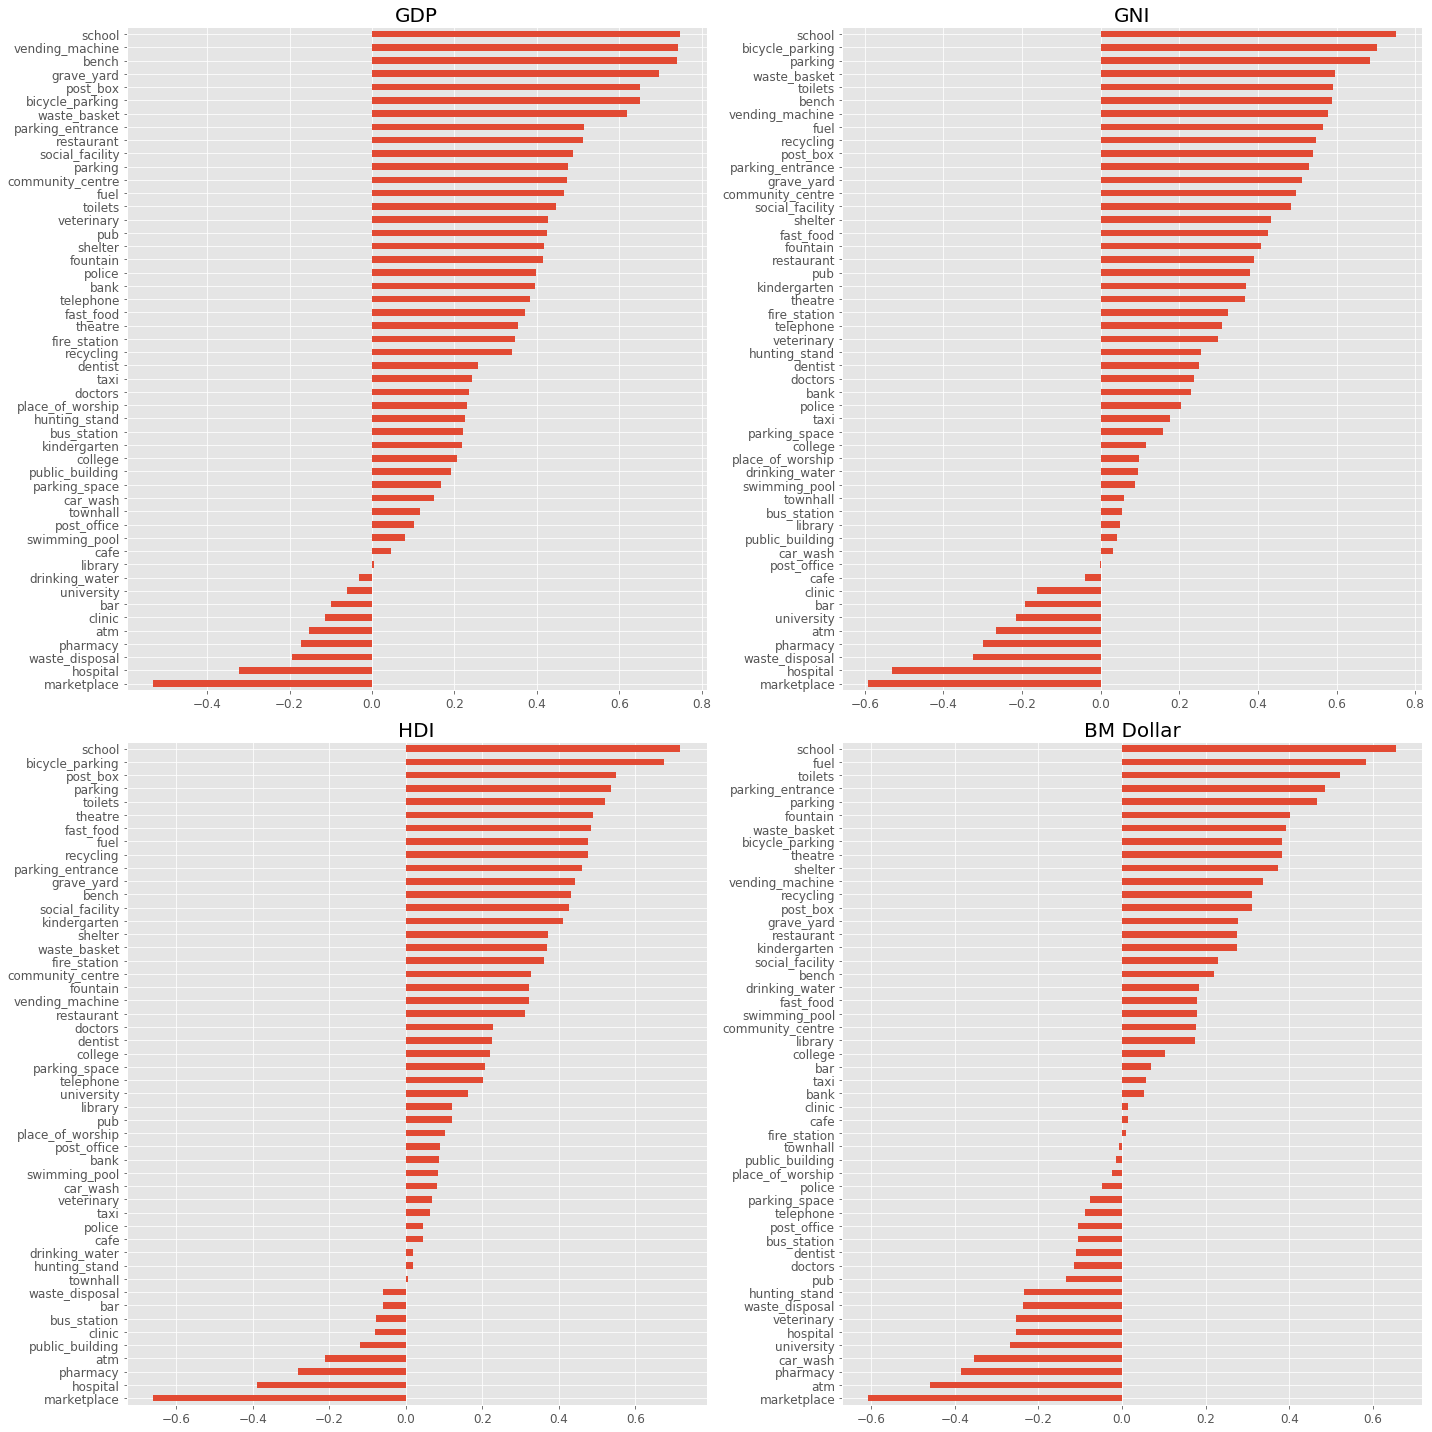

In [10]:
plt.figure(figsize=(20, 20))
for i, value in enumerate(['GDP', 'GNI', 'HDI', 'BM Dollar']):
    plt.subplot(2, 2, i + 1);
    df_corr[value].sort_values().plot(kind='barh', fontsize=12, 
                                      ax=plt.gca(), color='C0');
    plt.title(value, fontsize=20);
plt.tight_layout();

Curiously, we can see that school and marketplace seem to hold the strongest correlation for positive and negative correlation respectively. Let us take a closer look at the distributions.

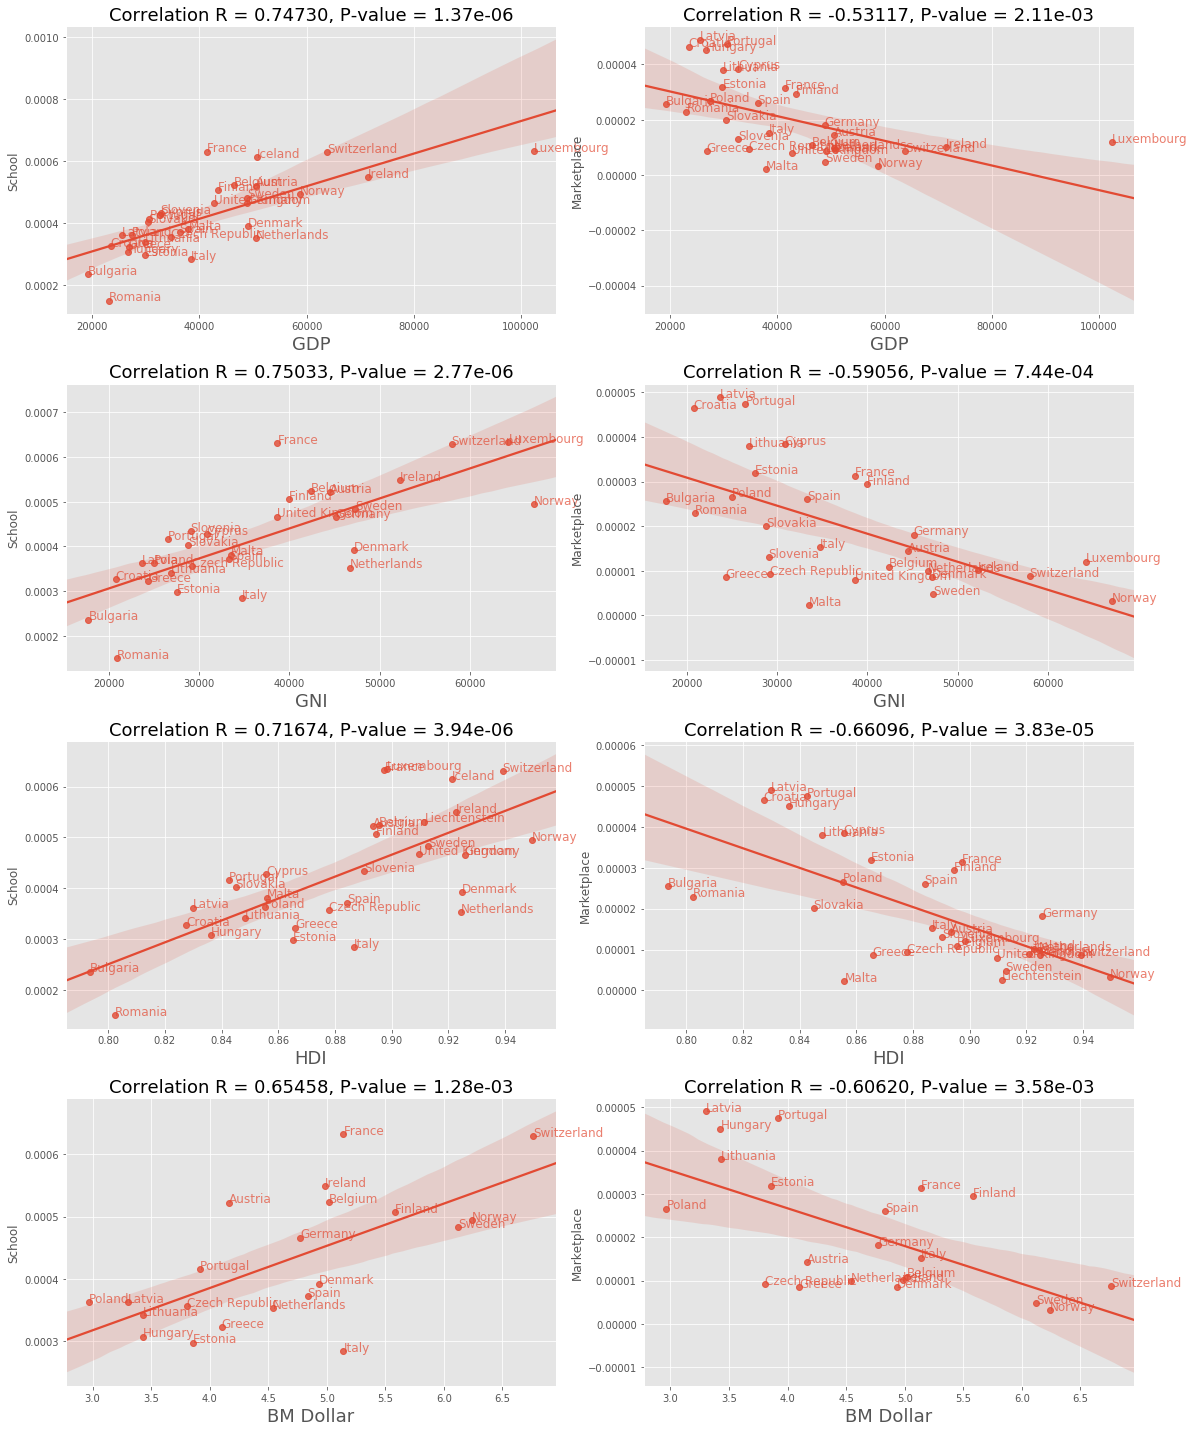

In [236]:
df_plot = pd.concat([df_targets, df_amenity_normalized], axis=1)

plt.figure(figsize=(16, 20))
for k, measurement in enumerate(['GDP', 'GNI', 'HDI', 'BM Dollar']):
    for i, amenity in enumerate(['school', 'marketplace']):
        plt.subplot(4, 2, 2*k + i + 1)
        sns.regplot(x=measurement, y=amenity, data=df_plot, fit_reg=True, ax=plt.gca())
        plt.ylabel(amenity.replace('_', ' ').title())
        plt.xlabel(measurement, fontsize=18)
        plt.title('Correlation R = {:.5f}, P-value = {:.2e}'.format(
            df_corr.loc[amenity][measurement],
            df_pvalues.loc[amenity][measurement]),
            fontsize=18)

        for i, country in enumerate(df_plot.index):
            if not np.isnan(df_plot[measurement][i]):
                plt.annotate(country, (df_plot[measurement][i], df_plot[amenity][i]), 
                             fontsize=12, color='C0', alpha=0.7)
plt.tight_layout()

Since we used economic indicators measuring similar things it should come as no surprise that we will find similar correlation within the amenities. It is still interesting to see that school and marketplace are consistent within those indicators. This would be interesting to extend to other countries to see if this consistency still holds.

# Conclusion

OpenStreetMap offers a great source to explore the hidden gems inside its vast data set and this project only scratched the surface of it. There is still a plethora of other things to explore and rabbit holes to fall into and as a living data set that is growing with each distribution the things to explore only increase. Finally, all the calculations and necessary scripts to collect the data from OSM can be found in this [repository](https://github.com/njanakiev/osm-predict-economic-measurements) and this [article]({{ site.baseurl }}{% link _posts/2018-03-04-openstreetmap-with-python-and-overpass-api.md %}) covers more details on how to load data from OSM with Python and the Overpass API.

Related to this topic, there is a great article on [Urban Form Analysis with OpenStreetMap Data](http://geoffboeing.com/2017/04/urban-form-analysis-openstreetmap/) by Geoff Boeing which talks about analysis and visualization of street networks and building footprints. Another good read is the article [OpenStreetMap past(s), and OpenStreetMap futures(s)](https://hi.stamen.com/openstreetmap-past-s-openstreetmap-future-s-cafddc2a4736) by Alan McConchie which explores the OSM users and the contributions over time. In the next article, we will explore what relationships can be found between countries and cities with their amenities.

## Used Data Sets and APIs

- [Human Development Index and its components](http://hdr.undp.org/en/composite/HDI) and [Human Development Data (1990-2015)](http://hdr.undp.org/en/data)
- [World Bank Open Data](https://data.worldbank.org/) with [wbdata](https://github.com/OliverSherouse/wbdata) by Sherouse, Oliver (2014). Arlington, VA. Available from http://github.com/OliverSherouse/wbdata.
- [The Big Mac Index](https://www.economist.com/content/big-mac-index)
- [OpenStreetMap](https://www.openstreetmap.org/) and [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API)
- [Taginfo](https://taginfo.openstreetmap.org/)